In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'

In [4]:
# https://scipython.com/blog/nuclear-binding-energies-1/
# Read the experimental data into a Pandas DataFrame.
df = pd.read_fwf('data/mass.mas03', usecols=(2,3,4,11),
              names=('N', 'Z', 'A', 'avEbind'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

In [6]:
df.head()

,N,Z,A,avEbind
0,0,1,1,0.0
1,1,1,2,1112.283
2,2,1,3,2827.266
3,1,2,3,2572.681
4,0,3,3,-2267#


In [7]:
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the avEbind column won't be numeric. Coerce to float and drop these entries.
df['avEbind'] = pd.to_numeric(df['avEbind'], errors='coerce')
df = df.dropna()
# Also convert from keV to MeV.
df['avEbind'] /= 1000

# Group the DataFrame by nucleon number, A.
gdf = df.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
maxavEbind = gdf.apply(lambda t: t[t.avEbind==t.avEbind.max()])

In [8]:
maxavEbind.head()

,,N,Z,A,avEbind
A,,,,,
1,0,0,1,1,0.000000
2,1,1,1,2,1.112283
3,2,2,1,3,2.827266
4,6,2,2,4,7.073915
5,9,3,2,5,5.481132


In [10]:
def SEMF(Z, N):
    """Calculate the average binding energy per nucleon for nucleus Z, N.

    Calculate the average nuclear binding energy per nucleon for a nucleus
    with Z protons and N neutrons, using the semi-empirical mass formula and
    parameters of J. W. Rohlf, "Modern Physics from alpha to Z0", Wiley (1994).

    Z and N can be NumPy arrays or scalar values.

    """

    # The parameterization of the SEMF to use.
    aV, aS, aC, aA, delta = 15.75, 17.8, 0.711, 23.7, 11.18

    # Covert Z and N to NumPy arrays if they aren't already
    Z, N = np.atleast_1d(Z), np.atleast_1d(N)
    # Total number of nucleons
    A = Z + N

    # The pairing term is -delta for Z and N both odd, +delta for Z and N both
    # even, and 0 otherwise. Create an array of the sign of this term so that
    # we can vectorize the calculation across the arrays Z and N.
    sgn = np.zeros(Z.shape)
    sgn[(Z%2) & (N%2)] = -1
    sgn[~(Z%2) & ~(N%2)] = +1

    # The SEMF for the average binding energy per nucleon.
    E = (aV - aS / A**(1/3) - aC * Z**2 / A**(4/3) -
         aA * (A-2*Z)**2/A**2 + sgn * delta/A**(3/2))

    # Return E as a scalar or array as appropriate to the input Z.
    if Z.shape[0] == 1:
        return float(E)
    return E

In [11]:
# Add a column of estimated binding energies calculated using the SEMF.
maxavEbind['Eapprox'] = SEMF(maxavEbind['Z'], maxavEbind['N'])

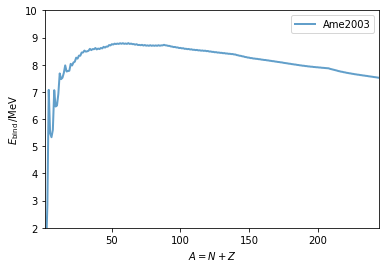

In [23]:
# Generate a plot comparing the experimental with the SEMF values.
fig, ax = plt.subplots()
ax.plot(maxavEbind['A'], maxavEbind['avEbind'], alpha=0.7, lw=2,
            label='Ame2003')
# ax.plot(maxavEbind['A'], maxavEbind['Eapprox'], alpha=0.7, lw=2, c='m',
#             label='SEMF')
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.legend()
# We don't expect the SEMF to work very well for light nuclei with small
# average binding energies, so display only data relevant to avEbind > 7 MeV.
ax.set_xlim(1, 245)
ax.set_ylim(2, 10);

In [24]:
df = maxavEbind

In [49]:
df['avEbind'] = -df['avEbind']

In [50]:
df.head()

,,N,Z,A,avEbind,Eapprox
A,,,,,,
1,0,0,1,1,-0.000000,-37.641000
2,1,1,1,2,-1.112283,-2.612757
3,2,2,1,3,-2.827266,0.610509
4,6,2,2,4,-7.073915,4.088801
5,9,3,2,5,-5.481132,4.059861


In [51]:
df.iloc[50:60]

,,N,Z,A,avEbind,Eapprox
A,,,,,,
51,424,28,23,51,-8.742051,8.733647
52,436,28,24,52,-8.775944,8.730831
53,448,29,24,53,-8.760155,8.743237
54,459,30,24,54,-8.777914,8.741643
55,472,30,25,55,-8.764988,8.749013
56,484,30,26,56,-8.790323,8.733176
57,496,31,26,57,-8.770249,8.751421
58,507,32,26,58,-8.792221,8.757118
59,520,32,27,59,-8.768013,8.750843


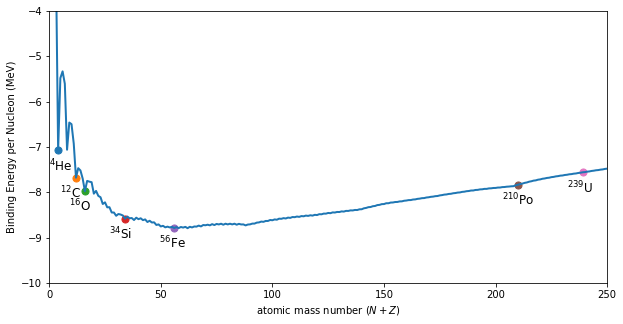

In [117]:
elements_names  = ['He', 'C', 'O', 'Si', 'Fe', 'Cs', 'Po', 'U']
elements_nr = [4, 12, 16, 34, 56, 137, 210, 239]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ymin, ymax = -10, -4
xmin, xmax = 0, 250
ax.plot(df['A'], df['avEbind'], alpha=1, lw=2, label='Ame2003')
for name, nr in zip(elements_names, elements_nr):
    ax.scatter(df['A'][nr], df['avEbind'][nr], alpha=1, s=50)
    if nr == 4:
        dx = 4
    else:
        dx = 7
    ax.text(df['A'][nr]-dx, df['avEbind'][nr]-0.45, f'$^{{{nr}}}$' + name, fontsize=12)
ax.set_xlabel(r'atomic mass number ($N + Z$)')
ax.set_ylabel('Binding Energy per Nucleon (MeV)')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax);